In [1]:
import pandas as pd
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data_path = "../data/combined_data_polester.csv"

In [3]:
# Load your dataset
df = pd.read_csv(data_path)

# Convert km/h to m/s
df["v_follower"] = df["Smooth Speed Follower"] * (1000 / 3600)
df["v_leader"] = df["Smooth Speed Leader"] * (1000 / 3600)
df.head()


,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader
0,0,1680.00,86.210,86.140,86.2380,86.1340,27.628521,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.955000,23.926111
1,1,1680.02,86.230,86.140,86.2426,86.1348,27.623119,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.956278,23.926333
2,2,1680.04,86.205,86.140,86.2444,86.1354,27.623431,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.956778,23.926500
3,3,1680.06,86.180,86.185,86.2462,86.1376,27.629303,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.957278,23.927111
4,4,1680.08,86.170,86.230,86.2486,86.1396,27.629145,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.957944,23.927667


In [4]:
# Compute relative speed and spacing
df["delta_v"] = df["v_follower"] - df["v_leader"]
df["spacing"] = df["Spacing"]  # Already in meters

# Estimate time step and acceleration
df["dt"] = df["Time"].diff()
df["acc_follower"] = df["v_follower"].diff() / df["dt"]

# Drop the first row (NaN)
df_cleaned = df.dropna(subset=["dt", "acc_follower"])

df_cleaned.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader,delta_v,spacing,dt,acc_follower
1,1,1680.02,86.230,86.140,86.2426,86.1348,27.623119,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.956278,23.926333,0.029944,27.623119,0.02,0.063889
2,2,1680.04,86.205,86.140,86.2444,86.1354,27.623431,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.956778,23.926500,0.030278,27.623431,0.02,0.025000
3,3,1680.06,86.180,86.185,86.2462,86.1376,27.629303,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.957278,23.927111,0.030167,27.629303,0.02,0.025000
4,4,1680.08,86.170,86.230,86.2486,86.1396,27.629145,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.957944,23.927667,0.030278,27.629145,0.02,0.033333
5,5,1680.10,86.160,86.150,86.2492,86.1364,27.623431,../data/Polestar 2/Polestar/Short/0_desired/55...,Short,0,55,25,23.958111,23.926778,0.031333,27.623431,0.02,0.008333


In [5]:
# One-hot encode the 'gap_setting' column
gap_dummies = pd.get_dummies(df_cleaned['gap_setting'], prefix='gap')

# Combine all selected features
features = pd.concat([
    df_cleaned[["spacing", "delta_v", "v_follower", "speed_fluctuation"]],
    gap_dummies
], axis=1)

# Keep the same target: follower accelerationtest
target = df_cleaned["acc_follower"]

In [6]:
features['gap_Medium'] = False
features['gap_Long'] = False
features['gap_XLong'] = False

In [7]:
features

,spacing,delta_v,v_follower,speed_fluctuation,gap_Short,gap_Medium,gap_Long,gap_XLong
1,27.623119,0.029944,23.956278,25,True,False,False,False
2,27.623431,0.030278,23.956778,25,True,False,False,False
3,27.629303,0.030167,23.957278,25,True,False,False,False
4,27.629145,0.030278,23.957944,25,True,False,False,False
5,27.623431,0.031333,23.958111,25,True,False,False,False
...,...,...,...,...,...,...,...,...
36356,34.628382,-0.040944,23.953833,45,True,False,False,False
36357,34.633406,-0.041000,23.954778,45,True,False,False,False
36358,34.632396,-0.040111,23.955389,45,True,False,False,False
36359,34.632396,-0.039556,23.955222,45,True,False,False,False


In [8]:
# spacing	delta_v	v_follower	speed_fluctuation	gap_Long	gap_Medium	gap_Short	gap_XLong

In [9]:
# Define the desired column order
gap_columns = ['gap_Long', 'gap_Medium', 'gap_Short', 'gap_XLong']

# Get the other columns in original order (excluding gap_columns)
other_columns = [col for col in features.columns if col not in gap_columns]

# Reorder the DataFrame
features = features[other_columns + gap_columns]

In [10]:
features

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong
1,27.623119,0.029944,23.956278,25,False,False,True,False
2,27.623431,0.030278,23.956778,25,False,False,True,False
3,27.629303,0.030167,23.957278,25,False,False,True,False
4,27.629145,0.030278,23.957944,25,False,False,True,False
5,27.623431,0.031333,23.958111,25,False,False,True,False
...,...,...,...,...,...,...,...,...
36356,34.628382,-0.040944,23.953833,45,False,False,True,False
36357,34.633406,-0.041000,23.954778,45,False,False,True,False
36358,34.632396,-0.040111,23.955389,45,False,False,True,False
36359,34.632396,-0.039556,23.955222,45,False,False,True,False


In [11]:
# Function to plot feature-target relationships for a specified index range
def plot_feature_target_range(features, target, start=0, end=100):
    plt.figure(figsize=(18, 5))

    # Slice the data for the specified range
    features_range = features.iloc[start:end]
    target_range = target.iloc[start:end]

    for i, column in enumerate(features_range.columns):
        plt.subplot(1, features.shape[1], i + 1)
        plt.scatter(features_range[column], target_range, alpha=0.6, s=20)
        plt.xlabel(column)
        plt.ylabel("Acceleration (m/s²)")
        plt.title(f"{column} vs Acceleration (Rows {start}–{end})")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

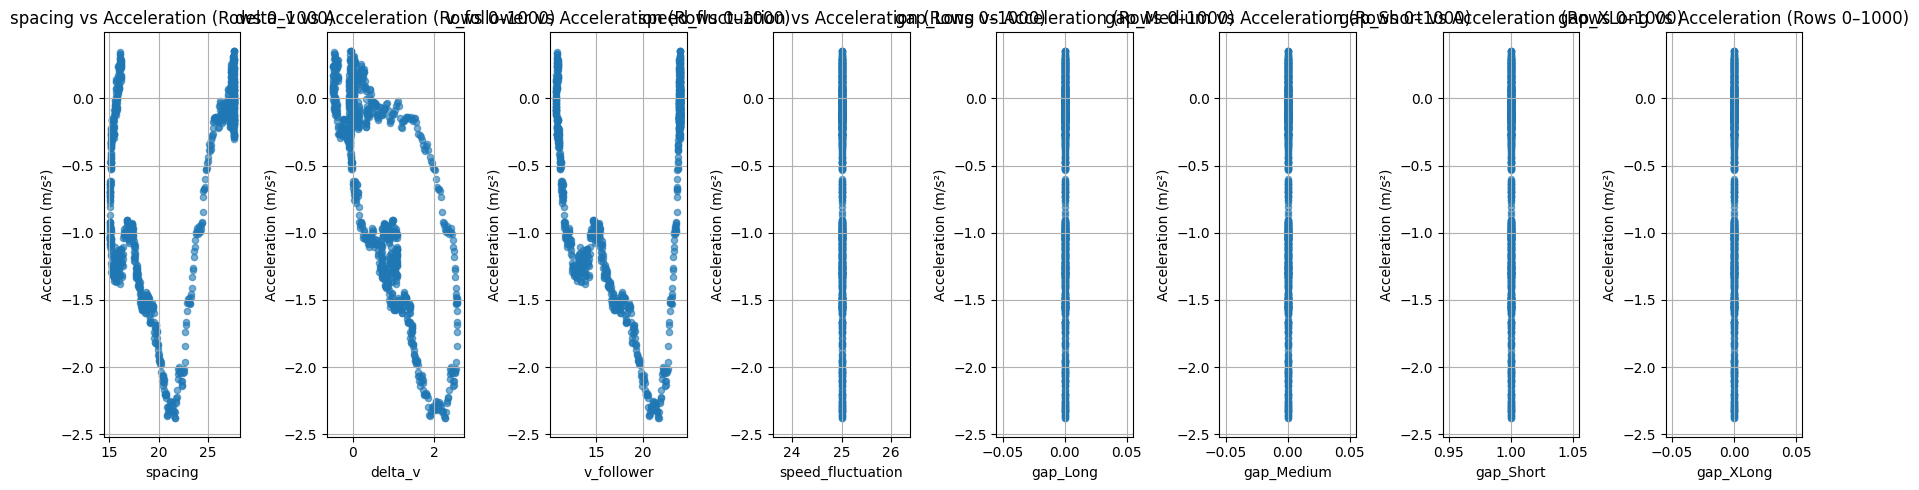

In [12]:
plot_feature_target_range(features, target, start=0, end=1000)

In [13]:
# laod model
# Load the model from the file
rf_model_loaded = joblib.load("rf_model_acceleration.pkl")


In [14]:
# Predict and evaluate
y_pred = rf_model_loaded.predict(features)
rmse = mean_squared_error(target, y_pred)
r2 = r2_score(target, y_pred)

rmse, r2

(0.25134567802293634, 0.0757640939693971)

In [15]:
target

1        0.063889
2        0.025000
3        0.025000
4        0.033333
5        0.008333
           ...   
36356    0.038889
36357    0.047222
36358    0.030556
36359   -0.008333
36360   -0.027778
Name: acc_follower, Length: 36360, dtype: float64

In [16]:
y_pred

array([0.00919444, 0.00919444, 0.00866667, ..., 0.37466667, 0.37561111,
       0.37419444], shape=(36360,))

In [17]:
# Calculate residuals (errors)
residuals = target - y_pred

## Residual Plot

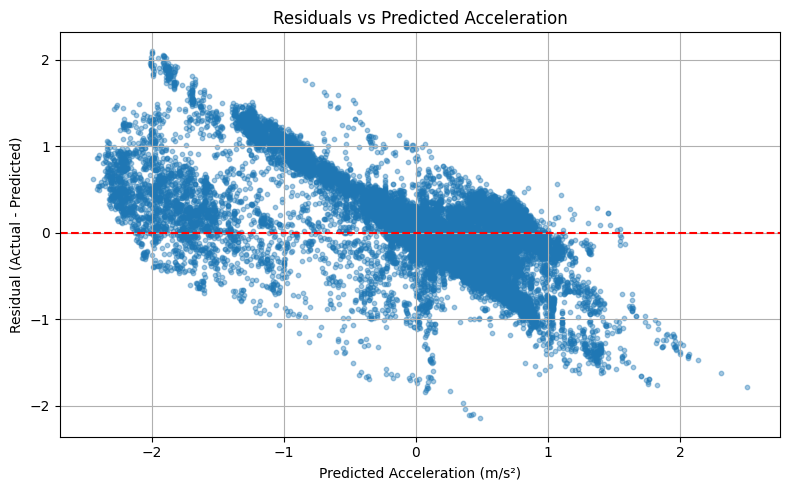

In [18]:
# Plot residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.4, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Acceleration")
plt.xlabel("Predicted Acceleration (m/s²)")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
reformed_df = features.copy()
reformed_df['acc_follower'] = target
reformed_df.head()

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower
1,27.623119,0.029944,23.956278,25,False,False,True,False,0.063889
2,27.623431,0.030278,23.956778,25,False,False,True,False,0.025000
3,27.629303,0.030167,23.957278,25,False,False,True,False,0.025000
4,27.629145,0.030278,23.957944,25,False,False,True,False,0.033333
5,27.623431,0.031333,23.958111,25,False,False,True,False,0.008333


In [20]:
reformed_df['pred_acc_follower'] = y_pred
reformed_df.head()

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower
1,27.623119,0.029944,23.956278,25,False,False,True,False,0.063889,0.009194
2,27.623431,0.030278,23.956778,25,False,False,True,False,0.025000,0.009194
3,27.629303,0.030167,23.957278,25,False,False,True,False,0.025000,0.008667
4,27.629145,0.030278,23.957944,25,False,False,True,False,0.033333,0.008667
5,27.623431,0.031333,23.958111,25,False,False,True,False,0.008333,0.009222


In [21]:
reformed_df['dt'] = 0.02
reformed_df

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower,dt
1,27.623119,0.029944,23.956278,25,False,False,True,False,0.063889,0.009194,0.02
2,27.623431,0.030278,23.956778,25,False,False,True,False,0.025000,0.009194,0.02
3,27.629303,0.030167,23.957278,25,False,False,True,False,0.025000,0.008667,0.02
4,27.629145,0.030278,23.957944,25,False,False,True,False,0.033333,0.008667,0.02
5,27.623431,0.031333,23.958111,25,False,False,True,False,0.008333,0.009222,0.02
...,...,...,...,...,...,...,...,...,...,...,...
36356,34.628382,-0.040944,23.953833,45,False,False,True,False,0.038889,0.378111,0.02
36357,34.633406,-0.041000,23.954778,45,False,False,True,False,0.047222,0.378111,0.02
36358,34.632396,-0.040111,23.955389,45,False,False,True,False,0.030556,0.374667,0.02
36359,34.632396,-0.039556,23.955222,45,False,False,True,False,-0.008333,0.375611,0.02


In [22]:
import numpy as np

def plot_acc_comparison_from_dataframe(df, actual_col="acc_follower", pred_col="pred_acc_follower", dt_col="dt", limit=(0, 1000),trajectory="Acceleration"):
    # Extract the desired range
    start, end = limit
    df_slice = df.iloc[start:end]

    # Compute time axis using cumulative dt
    time = np.cumsum(df_slice[dt_col].values)

    # Extract actual and predicted acceleration
    actual = df_slice[actual_col].values
    predicted = df_slice[pred_col].values

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(time, actual, label=f"Actual {trajectory}", linewidth=1.5)
    plt.plot(time, predicted, label=f"Predicted {trajectory}", linewidth=1.5, linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{trajectory} (m/s²)")
    plt.title(f"Actual vs Predicted {trajectory} (Rows {start}–{end})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [23]:
# Updated function to include a `limit` parameter for flexible range selection
def plot_actual_vs_predicted_acceleration(y_true, y_pred, limit=(0, 1000)):
    import matplotlib.pyplot as plt

    start, end = limit
    y_true_sample = y_true[start:end].reset_index(drop=True)
    y_pred_sample = pd.Series(y_pred[start:end])

    plt.figure(figsize=(12, 6))
    plt.plot(y_true_sample, label='Actual Acceleration', linewidth=1.5)
    plt.plot(y_pred_sample, label='Predicted Acceleration', linewidth=1.5, linestyle='--')
    plt.title(f"Actual vs Predicted Acceleration (Index {start} to {end})")
    plt.xlabel("Time Step (index)")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

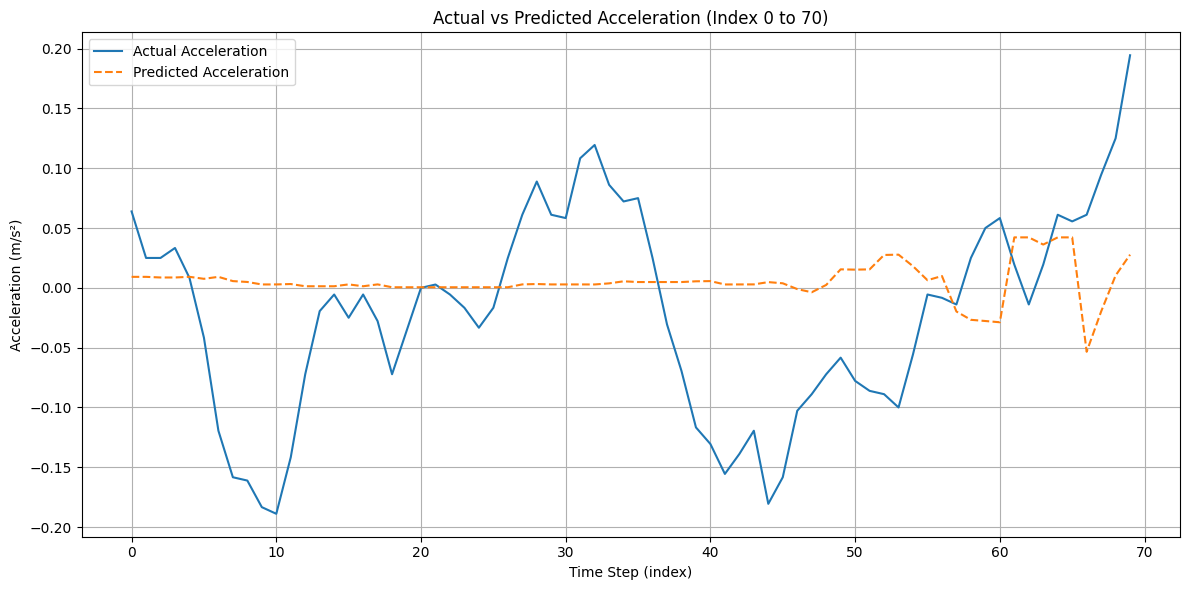

In [24]:
# Example usage with limit range
plot_actual_vs_predicted_acceleration(target.reset_index(drop=True), y_pred, limit=(0, 70))

In [25]:
def compute_predicted_speed(df, acc_col="pred_acc_follower", dt_col="dt", 
                            initial_speed_col="v_follower", output_col="pred_speed_follower"):
    predicted_speed = [df[initial_speed_col].iloc[0]]  # start with the actual initial speed
    for i in range(1, len(df)):
        dt = df[dt_col].iloc[i]
        acc = df[acc_col].iloc[i - 1]
        v_new = predicted_speed[-1] + acc * dt
        predicted_speed.append(v_new)
    
    df[output_col] = predicted_speed
    return df

In [26]:
reformed_df = compute_predicted_speed(reformed_df)

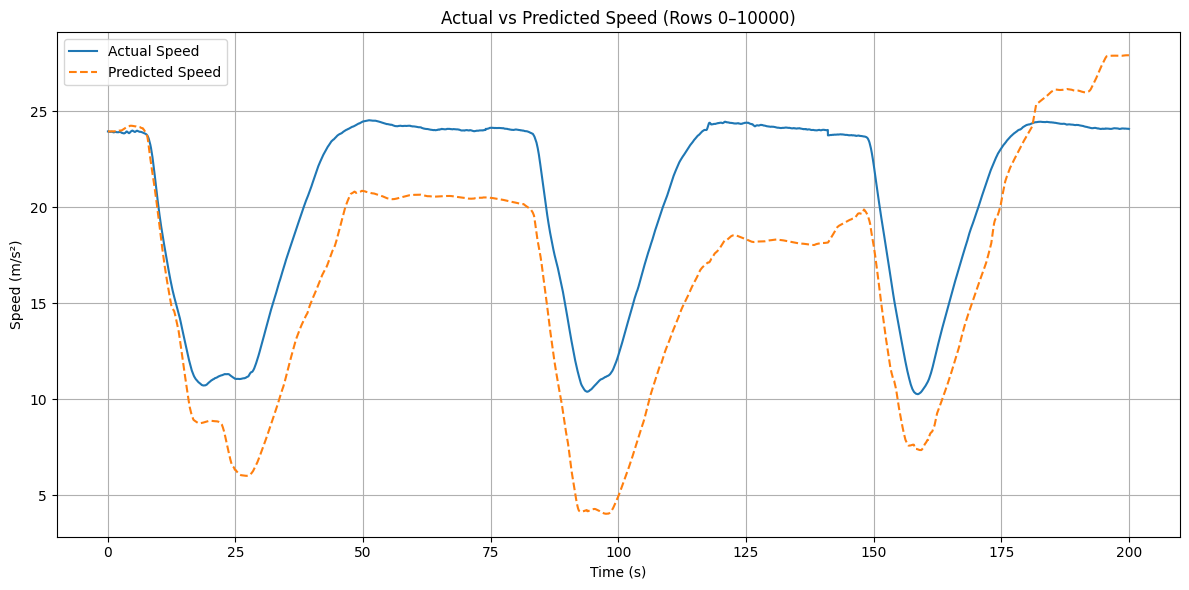

In [27]:
plot_acc_comparison_from_dataframe(reformed_df, actual_col="v_follower", pred_col="pred_speed_follower", dt_col="dt", limit=(0, 10000),trajectory="Speed")